## Categorical Feature Encoding Challenge
- 해당 조건에서 target(고양이)가 있는지 없는지 예측하는 문제
- score: AUC
- [참조한 커널](https://www.kaggle.com/deepshekhar/categorical-feature-encoding-challenge)
- [OH my cat](https://www.kaggle.com/superant/oh-my-cat)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks') # 그래프를 seaborn 스타일로 그리기
plt.rc('font', family = 'Malgun Gothic') # 한글 처리

from sklearn.linear_model import LogisticRegression
import scipy
from tqdm import tqdm_notebook as tqdm

In [3]:
%%time
train = pd.read_csv("../input/cat-in-the-dat/train.csv")
test = pd.read_csv("../input/cat-in-the-dat/test.csv")

print(train.shape)
print(test.shape)

(300000, 25)
(200000, 24)
CPU times: user 2.15 s, sys: 197 ms, total: 2.34 s
Wall time: 2.16 s


### 데이터 탐색

In [6]:
print(train.columns)
train.head()
#ord_5를 두개의 컬럼으로 나누기!!!
#ord_2를 온도로 매핑하기?? 일반적인 차가운 온도 or 1,2,3,4,5 같이 순서 있게

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [4]:
train['target'].value_counts()

0    208236
1     91764
Name: target, dtype: int64

In [8]:
# unique한 값 개수
train['nom_9'].unique().shape[0]

11981

In [19]:
print(train['ord_3'].unique().shape[0]) #알파벳 26개 중 15개(소문자)
print(train['ord_4'].unique().shape[0]) #모든 알파벳 있음(대문자)

15
26


2    74315
1    67144
3    66357
4    40434
7    33051
5    17787
6      912
Name: day, dtype: int64
2     45305
3     40867
1     40848
11    25732
12    25204
4     24920
9     24857
10    22112
7     19867
8     18730
5     10995
6       563
Name: month, dtype: int64


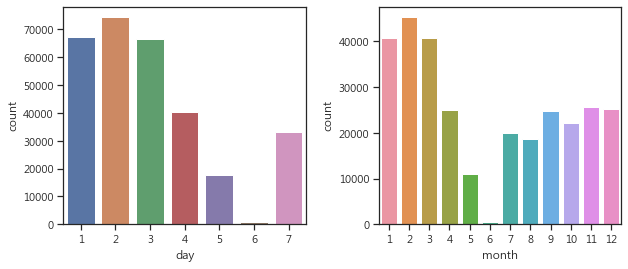

In [35]:
print(train['day'].value_counts()) # 6번째 요일(일요일일 듯)이 압도적으로 적음
print(train['month'].value_counts()) # 6월이 압도적으로 적음

plt.figure(figsize = (10, 4))
plt.subplot(121)
sns.countplot(train['day'])
plt.subplot(122)
sns.countplot(train['month'])
plt.subplots_adjust(wspace = 0.3)

In [10]:
train['ord_2'].unique()
# 뜨겁고 차가운 정도 순서 매기기 -> 매겼네!! 커널은

array(['Cold', 'Hot', 'Lava Hot', 'Boiling Hot', 'Freezing', 'Warm'],
      dtype=object)

In [42]:
# .head()에서 보이지 않는 nom 변수들
for col in train.columns:
    if "nom" in col:
        uniq = train[col].unique().shape[0]
        print('unique 개수:', uniq)
        if uniq > 10:
            print("head")
            print(train[col].head(3))
        else:
            print("unique:", train[col].unique())
        print("-" * 20)

unique 개수: 3
unique: ['Green' 'Blue' 'Red']
--------------------
unique 개수: 6
unique: ['Triangle' 'Trapezoid' 'Polygon' 'Square' 'Star' 'Circle']
--------------------
unique 개수: 6
unique: ['Snake' 'Hamster' 'Lion' 'Cat' 'Dog' 'Axolotl']
--------------------
unique 개수: 6
unique: ['Finland' 'Russia' 'Canada' 'Costa Rica' 'China' 'India']
--------------------
unique 개수: 4
unique: ['Bassoon' 'Piano' 'Theremin' 'Oboe']
--------------------
unique 개수: 222
head
0    50f116bcf
1    b3b4d25d0
2    3263bdce5
Name: nom_5, dtype: object
--------------------
unique 개수: 522
head
0    3ac1b8814
1    fbcb50fc1
2    0922e3cb8
Name: nom_6, dtype: object
--------------------
unique 개수: 1220
head
0    68f6ad3e9
1    3b6dd5612
2    a6a36f527
Name: nom_7, dtype: object
--------------------
unique 개수: 2215
head
0    c389000ab
1    4cd920251
2    de9c9f684
Name: nom_8, dtype: object
--------------------
unique 개수: 11981
head
0    2f4cb3d51
1    f83c56c21
2    ae6800dd0
Name: nom_9, dtype: object
-------------

### Feature Engineering
- 다 하고 데이터 pkl로 저장하기

In [92]:
ddall = train.append(test, sort = False)
num_train = len(train)
print(test.shape[0])
print(ddall['target'].isnull().sum())
ddall.head()

In [76]:
print(ddall['bin_0'].value_counts())
print(ddall['ord_0'].value_counts())

0    436334
1     63666
Name: bin_0, dtype: int64
1    324891
2    110784
3     64325
Name: ord_0, dtype: int64


In [112]:
drop_cols = ['bin_0']
#drop_cols = []
ddall['ord_5a'] = ddall['ord_5'].str[0]
ddall['ord_5b'] = ddall['ord_5'].str[1]
drop_cols.append('ord_5')

In [113]:
drop_cols

['bin_0', 'ord_5']

In [86]:
# 5a -> 대소문자 26개씩. 총 52개
# 5b -> 딱 하나 빠진 총 51개
print(ddall['ord_5a'].unique())
print(ddall['ord_5b'].unique())

['k' 'b' 'J' 'q' 'P' 'w' 'E' 'C' 's' 'd' 'a' 'M' 'o' 'R' 'f' 'g' 'H' 'T'
 'S' 'e' 'K' 'V' 'F' 'Y' 'l' 'Q' 'B' 'h' 'n' 'u' 'D' 'X' 'r' 'U' 'y' 'G'
 'j' 'c' 'm' 'v' 'Z' 't' 'x' 'A' 'W' 'N' 'i' 'I' 'O' 'L' 'p' 'z']
['r' 'F' 'c' 'W' 'P' 'Z' 'y' 'd' 'o' 'X' 'u' 'V' 'C' 'L' 'h' 'J' 'j' 'R'
 'Q' 'K' 'M' 'f' 'O' 'g' 'x' 'b' 'G' 'e' 'A' 'T' 'v' 'S' 't' 'i' 'n' 'D'
 'q' 'p' 'U' 'E' 'm' 'k' 'I' 'N' 'w' 'B' 's' 'Y' 'l' 'H' 'a']


In [62]:
# train, test 모두에 들어있지 않는 값을 single value('xor')로 변경
for col in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    train_vals = set(train[col].unique())
    test_vals = set(test[col].unique())
    
    # ^ 연산 -> XOR(같으면 0, 다르면 1). 교집합 제외한 나머지가 남음
    xor_cat_vals = train_vals ^ test_vals
    print("XOR 값 수:", len(xor_cat_vals))
    if xor_cat_vals:
        ddall.loc[ddall[col].isin(xor_cat_vals), col] = 'xor'

XOR 값 수: 0
XOR 값 수: 0
XOR 값 수: 1
XOR 값 수: 9
XOR 값 수: 316


In [117]:
drop_cols

['bin_0', 'ord_5']

In [116]:
%%time
# 전부 One-Hot Encoding
X = ddall[ddall.columns.difference(['id', 'target'] + drop_cols)] #해당 칼럼들을 뺀 것.
# 아래 6개 칼럼은 원핫 안함. 왜 이것들만??
X_oh = X[X.columns.difference(['ord_1', 'ord_4', 'ord_5a', 'ord_5b', 'day', 'month'])]
oh1 = pd.get_dummies(X_oh, columns = X_oh.columns, drop_first=True, sparse=True)
ohc1 = oh1.to_coo()
ohc1

CPU times: user 17.8 s, sys: 414 ms, total: 18.2 s
Wall time: 15.2 s


<500000x15968 sparse matrix of type '<class 'numpy.uint8'>'
	with 6430440 stored elements in COOrdinate format>

### Thermometer encoder
- 순서 있는 ordinal column 처리

In [73]:
from sklearn.base import TransformerMixin
from itertools import repeat

In [74]:
class ThermometerEncoder(TransformerMixin):
    def __init__(self, sort_key=None):
        self.sort_key = sort_key
        self.value_map_ = None
    
    def fit(self, X, y=None):
        self.value_map_ = {val: i for i, val in enumerate(sorted(X.unique(), key=self.sort_key))}
        return self
    
    def transform(self, X, y=None):
        values = X.map(self.value_map_)
        
        possible_values = sorted(self.value_map_.values())
        
        idx1 = []
        idx2 = []
        
        all_indices = np.arange(len(X))
        
        for idx, val in enumerate(possible_values[:-1]):
            new_idxs = all_indices[values > val]
            idx1.extend(new_idxs)
            idx2.extend(repeat(idx, len(new_idxs)))
            
        result = scipy.sparse.coo_matrix(
            ([1] * len(idx1), (idx1, idx2)), 
            shape=(len(X), len(possible_values)), dtype="int8")
            
        return result

In [78]:
for col in ['ord_1', 'ord_2']:
    print(ddall[col].value_counts())

Novice         210877
Grandmaster    129143
Contributor     71516
Master          46755
Expert          41709
Name: ord_1, dtype: int64
Freezing       166065
Lava Hot       106649
Boiling Hot    101263
Cold            56434
Hot             36744
Warm            32845
Name: ord_2, dtype: int64


In [88]:
%%time
thermos = []
for col in ["ord_1", "ord_2", "ord_3", "ord_4", "ord_5a", "day", "month"]:
    if col == 'ord_1':
        sort_key = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'].index
    elif col == 'ord_2':
        sort_key = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot'].index
    elif col in ['ord_3', 'ord_4', 'ord_5a']: #알파벳 데이터. 왜 ord_5b는 안하지??
        sort_key = str
    elif col in ['day', 'month']:
        sort_key = int
    else:
        raise ValueError(col)
        
    encoder = ThermometerEncoder(sort_key=sort_key)
    thermos.append(encoder.fit_transform(X[col]))

CPU times: user 12.7 s, sys: 1.04 s, total: 13.7 s
Wall time: 13.9 s


### Sparse Matrix 결합

In [118]:
ohc = scipy.sparse.hstack([ohc1] + thermos).tocsr()
display(ohc)

<500000x16091 sparse matrix of type '<class 'numpy.int16'>'
	with 34244885 stored elements in Compressed Sparse Row format>

In [119]:
X_train = ohc[:num_train]
X_test = ohc[num_train:]
y_train = train['target'].values

print(X_train.shape) #아까 X 걸러내는 과정에서 target 칼럼 뺐음 -> test와 차원이 같음
print(X_test.shape)

(300000, 16091)
(200000, 16091)


### Modeling
- fold 100번만 돌리고 비교해 보기
- drop_0 칼럼 제거하면 성능 조금 좋아지는데, 이걸 backward elimination으로 제거할 수 있는지?? 제거할 칼럼 중에 포함되어 있을 것 같은데.

In [120]:
%%time
clf = LogisticRegression(solver='lbfgs', max_iter=5000)
clf.fit(X_train, y_train)

pred = clf.predict_proba(X_test)[:, 1]
pd.DataFrame({
    "id": test['id'],
    "target": pred
}).to_csv("../output/cat_chal/1028_submission_3_iter5000.csv", index = False)

/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 16.6 s, sys: 473 ms, total: 17.1 s
Wall time: 9.44 s


### Evaluate

In [121]:
# Fail to Converge?
from sklearn.model_selection import cross_validate

score = cross_validate(clf, X_train, y_train, cv = 3, scoring = 'roc_auc')['test_score'].mean()
print(f"{score:.6f}")

/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.797252


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
%%time
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_idx], align = 'center')
ax.set_yticks(pos)
#ax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize = 8)
ax.set_ylabel('Relative Feature Importance')

plt.tight_layout()
plt.show()

### 일단 lightGBM으로 때려 박아봄

In [6]:
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc, os, pickle

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [7]:
for col in train.columns:
    print(col, "dtype:", train[col].dtype)

id dtype: int64
bin_0 dtype: int64
bin_1 dtype: int64
bin_2 dtype: int64
bin_3 dtype: object
bin_4 dtype: object
nom_0 dtype: object
nom_1 dtype: object
nom_2 dtype: object
nom_3 dtype: object
nom_4 dtype: object
nom_5 dtype: object
nom_6 dtype: object
nom_7 dtype: object
nom_8 dtype: object
nom_9 dtype: object
ord_0 dtype: int64
ord_1 dtype: object
ord_2 dtype: object
ord_3 dtype: object
ord_4 dtype: object
ord_5 dtype: object
day dtype: int64
month dtype: int64
target dtype: int64


In [30]:
%%time
# object 형식 data type이 많음 -> Label Encoding
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        # fit 한 부분 커널 보고 수정하기
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))
        
#Category Encoders (github) -> train에 안 나왔던게 test에도 나왔기 때문

ValueError: y contains previously unseen labels: ['1f0a80e1d', '2be51c868', 'a9bf3dc47', 'ec337ce4c']

In [25]:
from sklearn.model_selection import KFold

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [26]:
%%time
X = train.drop(['target'], axis=1)
y = train['target']

X_test = test

del train, test
gc.collect()

Wall time: 153 ms


11

In [27]:
print(X.shape)
print(X_test.shape)

(300000, 24)
(200000, 24)


In [28]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields nom_8, nom_9